In [1]:
# importing general packages

import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate
import sys
sys.path.append('/Users/milena/Desktop/snowmass/gammaALPs/') # path to calc_alp_signal script
import os
from calc_alp_signal import ALPSNSignal

In [2]:
# computing the ALP spectrum stuff:

EMeV = np.linspace(1.,1000.,500)
ts = np.linspace(0.,30.,500)
ee, tt = np.meshgrid(EMeV,ts, indexing = 'ij')


# mass = 10 solar masses

alp_sn10 = ALPSNSignal(Mprog = 10.)
dndedt_alp10 = alp_sn10(EMeV, ts, g10=0.1)

# mass = 18 solar masses 

alp_sn18 = ALPSNSignal(Mprog = 18.)
dndedt_alp18 = alp_sn18(EMeV, ts, g10=0.1)

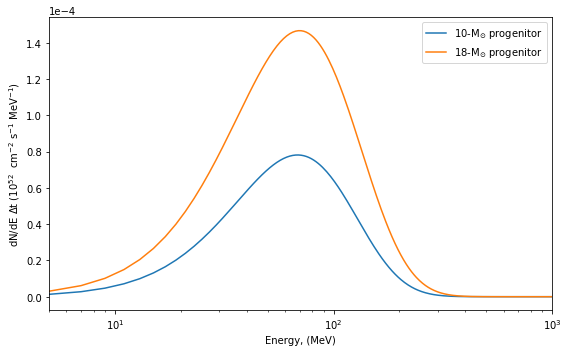

In [3]:
SED10 = integrate.simps(dndedt_alp10, tt, axis = 1)/tt.max() # using the average for 10 solar masses
SED18 = integrate.simps(dndedt_alp18, tt, axis = 1)/tt.max() # using the average for 18 solar masses

# both in units of 10^52 ph/MeV/s
plt.figure(figsize=(8,5))
plt.plot(EMeV, SED10,  label = '10-M$_{\\odot}$ progenitor')
plt.plot(EMeV, SED18,  label = '18-M$_{\\odot}$ progenitor')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xscale('log')
plt.xlim(5,1000)
plt.xlabel('Energy, (MeV)')
plt.ylabel('dN/dE $\Delta$t ($10^{52}$  cm$^{-2}$ s$^{-1}$ MeV$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# defining the ALP spectrum normalization:

def d(N,g,P):
    """d in cm, g in GeV^-1, N in cm^-2"""
    pc2cm = 3.086e+18 
    a = 8.4e-54
    g0 = 1e-11
    d0 = 1e7*pc2cm
    return d0*((0.1/P)*(N/a)*(g0/g)**4)**(-1./2) # in cm

def N(d, g, P):
    """d in Mpc, g in GeV^-1, N in cm^-2"""
    a = 8.4e-54
    g0 = 1e-11
    return a * ((10/d)**(2)) * (g/g0)**4 * (P/0.1)

In [5]:
# Considering the distance of 5 Mpc

N5 = N(d = 5, g=1e-11, P=0.1)
print "The normalization corresponding the the 5 Mpc distance is N = %.2e cm^-2." %N5

The normalization corresponding the the 5 Mpc distance is N = 3.36e-53 cm^-2.


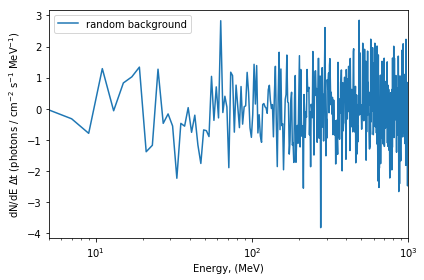

In [6]:
# Creating a random level of background

bkg = np.random.normal(0,1, len(SED10))#(len(SED10)) # random uncertainty
plt.plot(EMeV, bkg, label='random background')
#plt.plot(EMeV, N5*SED10*1e52+bkg, label ='signal+background')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xscale('log')
plt.xlim(5,1000)
plt.xlabel('Energy, (MeV)')
plt.ylabel('dN/dE $\Delta$t (photons / cm$^{-2}$ s$^{-1}$ MeV$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
def ALPmodel(x, norm):
    """Model to fit, for t=30 s, M=10 Msun, and g10=0.1"""
    x = EMeV
    return SED10*norm

def BKGmodel(x, norm):
    """Model to fit, for t=30 s, M=10 Msun, and g10=0.1"""
    x = EMeV
    return np.zeros(len(EMeV))*norm

In [8]:
from lmfit import Model
ALPmod = Model(ALPmodel)
BKGmod = Model(BKGmodel)

In [9]:
bkg_norm = np.logspace(-6, -3, 10)
ALP_bkg = np.zeros((len(bkg_norm), len(SED10)))

# Spectra with the different background levels
for i in range(len(bkg_norm)):
    ALP_bkg[i, :] = bkg_norm[i]*bkg + N5*SED10*1e52

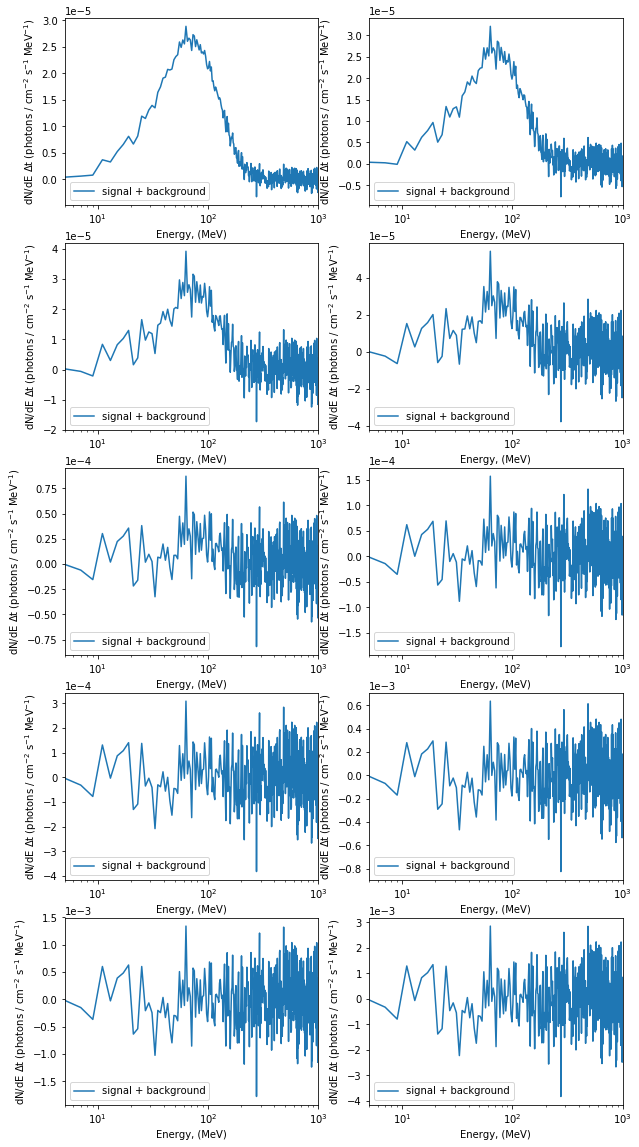

In [10]:
fig, axs = plt.subplots(5,2,figsize=(10,20))

for i in range(len(bkg_norm)):
    plt.subplot(5,2,i+1)
    plt.plot(EMeV, ALP_bkg[i, :], label='signal + background')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xscale('log')
    plt.xlim(5,1000)
    plt.xlabel('Energy, (MeV)')
    plt.ylabel('dN/dE $\Delta$t (photons / cm$^{-2}$ s$^{-1}$ MeV$^{-1}$)')
    plt.legend()


In [11]:
result_BKG = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
result_ALP = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
bic = np.zeros(len(bkg_norm))

for i in range(len(bkg_norm)):
    result_BKG[i] = BKGmod.fit(ALP_bkg[i, :], x=EMeV, norm=1)
    result_ALP[i] = ALPmod.fit(ALP_bkg[i, :], x=EMeV, norm=N5*1e52)
    # lowest bic preferred
    bic[i] = result_BKG[i].bic - result_ALP[i].bic
    
print bic

[2.01846537e+03 1.27874995e+03 6.29893002e+02 2.11209191e+02
 4.99193463e+01 9.41933308e+00 1.32501007e+00 6.51302570e-02
 2.59101701e-02 1.25401902e-01]


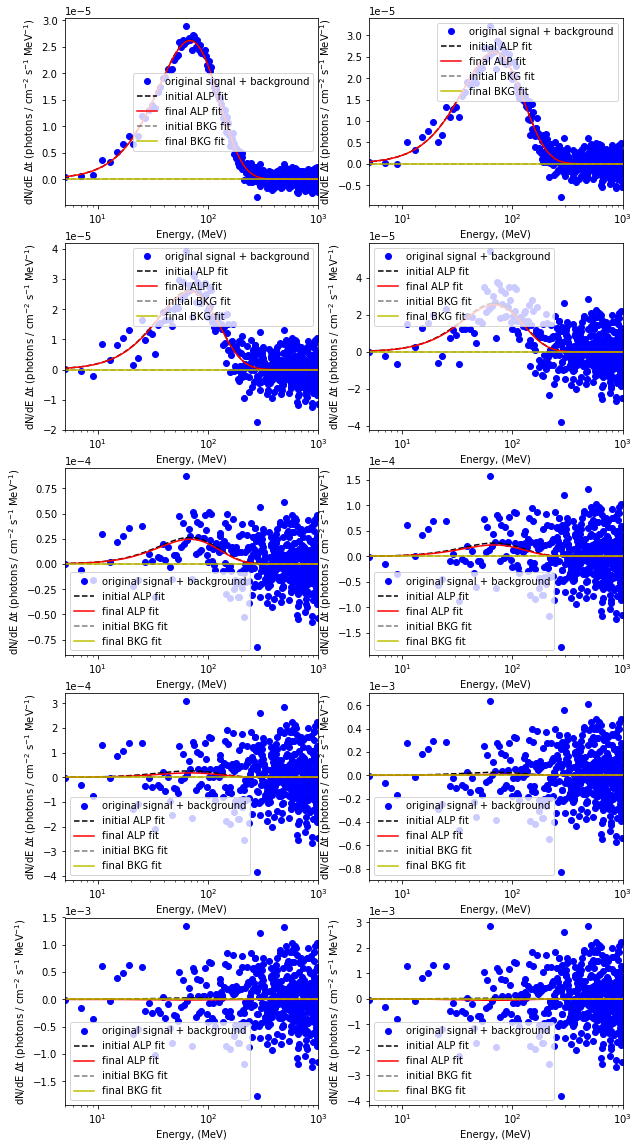

In [12]:
fig, axs = plt.subplots(5,2,figsize=(10,20))

for i in range(len(bkg_norm)):
    plt.subplot(5,2,i+1)
    
    plt.plot(EMeV, ALP_bkg[i, :], 'bo', label='original signal + background')
    plt.plot(EMeV, result_ALP[i].init_fit, 'k--', label = 'initial ALP fit')
    plt.plot(EMeV, result_ALP[i].best_fit, 'r-', label = 'final ALP fit')
    plt.plot(EMeV, result_BKG[i].init_fit, 'k--', alpha=0.5, label = 'initial BKG fit')
    plt.plot(EMeV, result_BKG[i].best_fit, 'y-', label = 'final BKG fit')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xscale('log')
    plt.xlim(5,1000)
    plt.xlabel('Energy, (MeV)')
    plt.ylabel('dN/dE $\Delta$t (photons / cm$^{-2}$ s$^{-1}$ MeV$^{-1}$)')
    plt.legend()